In [5]:
import pandas as pd 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA


In [9]:
df_raw = pd.read_csv('D:/data/2/환율.csv', parse_dates=['APPL_DATE'])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


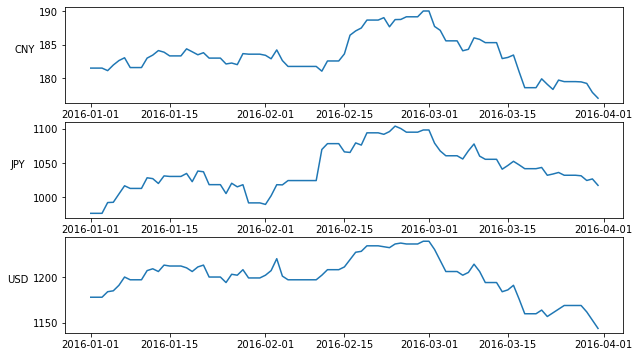

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize=(10, 6))

for (ax,idx, currency) in zip([ax1, ax2, ax3],[311,312,313],["CNY","JPY","USD"]):
     ax.plot("APPL_DATE","STD_RATE", data=df_raw[df_raw["CURRENCY"] == currency])
      # y축에 통화표시 rotation: label가로로 생성, labelpad :label과 그래프 사이 거리
     ax.set_ylabel(currency, rotation = 0, labelpad = 15)


In [13]:
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx) / len_idx) <  train_size 
mask


NameError: name 'df_CNY' is not defined

In [ ]:
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print("shape of train data : {}".format(df_CNY_train.shape))
print("shape of test data :  {}".format(df_CNY_test.shape))


In [ ]:
# 추가설명 : Train & Test 데이터 분할 : index 직접 지정
df_CNY_train = df_CNY[df_CNY.index <= "2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index > "2016-03-22"]
df_CNY_test


In [ ]:
# 원데이터 : z(t)          
df_CNY_train.plot()


In [ ]:
# 1차 차분: z(t) – z(t-1)
# shift(n): 앞의 n번 째 행의 데이터를 가져옴
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()


In [ ]:
# 2차 차분: (z(t) – z(t-1)) - (z(t-1) - z(t-2)) = z(t) – 2*z(t-1) + z(t-2)
df_CNY_diff2 = df_CNY_train - 2 * (df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()


In [ ]:
# AR(자기회귀) 최대 p기간 지정
lag_size = 30
fig = plt.figure(figsize=(12,8))

# acf 그래프를 그릴 공간 생성
ax1 = fig.add_subplot(211)

# 자기상관함수 그래프 : plot_acf 함수 사용 
fig = plot_acf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax1)

# pacf 그래프를 그릴 공간 생성
ax2 = fig.add_subplot(212)

# 부분자기상관 함수 그래프 : plot_pacf 함수 사용 
fig = plot_pacf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax2)


In [15]:
import warnings
warnings.filterwarnings('ignore')

# Train 데이터 이용, AR(1), I(2, 차분), MA(0)인 ARIMA 모델
# ts_model_cny = ARIMA(df_CNY_train, order = (0, 2, 1))  # (p,d,q) 지정
ts_model_cny = sm.tsa.arima.ARIMA(df_CNY, order=(0,2,1)) 

# trend: 상수 포함 여부 "nc"이면 상수 미포함, full_output: 모든 출력 결과 표시
ts_result_cny = ts_model_cny.fit(trend = "c", full_output = True)
print(ts_result_cny.summary())


NameError: name 'df_CNY_train' is not defined

In [ ]:
# 연습 
ts_model_cny = ARIMA(df_CNY_train, order = (0, 2, 1))  # (p,d,q) 지정
ts_result_cny = ts_model_cny.fit()
print(ts_result_cny.aic)


In [ ]:
# 예측 시작/종료 날짜 지정
start_time = df_CNY_test.index.min()        # 2016-03-23
end_time = df_CNY_test.index.max()          # 2016-03-31
fig, ax = plt.subplots(figsize = (12, 8))

# 예측 전까지 데이터
ax = df_CNY_train.plot(ax = ax)

# 예측그래프생성(start:예측시작,end:예측종료) plot_insample:예측구간과 겹치는 구간표시
fig = ts_result_cny.plot_predict(start=start_time, end=end_time, ax = ax, 
                                 plot_insample=False)


In [ ]:
# 전체 기간의 실제값, 예측값 확인 
# 차분 = 2 -> 시작일자 + 2 이후부터 예측값 생성됨
start_time = pd.to_datetime("2016-01-03")  
y_pred = ts_result_cny.predict(start=start_time, end=end_time, typ='levels')

# 실제값 저장
df_merge = df_CNY  

# 예측값 저장 및 변수명 지정
df_merge["예측값"]=y_pred  
df_merge.head().round(2)


In [ ]:
# 추세 그래프 생성 및 확인
df_merge.plot( y = ["STD_RATE","예측값"], figsize=(15,7))
